<a href="https://colab.research.google.com/github/keerthireddy-28/ExplainableAi/blob/main/Explainable_AI_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install pdpbox --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.7 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import shap
import lime
from lime import lime_tabular
from sklearn.inspection import partial_dependence


Dataset Shape: (1000, 10)

Data Types:
 age                            int64
gender                        object
pack_years                   float64
radon_exposure                object
asbestos_exposure             object
secondhand_smoke_exposure     object
copd_diagnosis                object
alcohol_consumption           object
family_history                object
lung_cancer                   object
dtype: object

Missing Values:
 age                            0
gender                         0
pack_years                     0
radon_exposure                 0
asbestos_exposure              0
secondhand_smoke_exposure      0
copd_diagnosis                 0
alcohol_consumption          334
family_history                 0
lung_cancer                    0
dtype: int64

Summary Statistics:
                age   pack_years
count  1000.000000  1000.000000
mean     56.994000    49.090413
std      23.605363    28.778144
min      18.000000     0.408278
25%      36.000000    23.905660
5

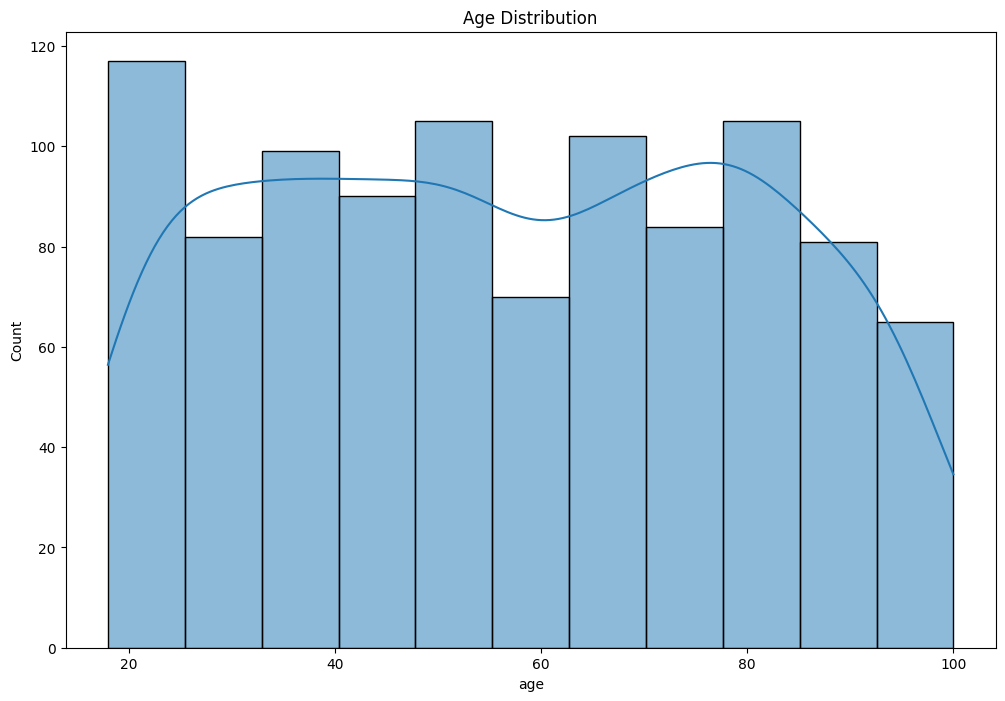

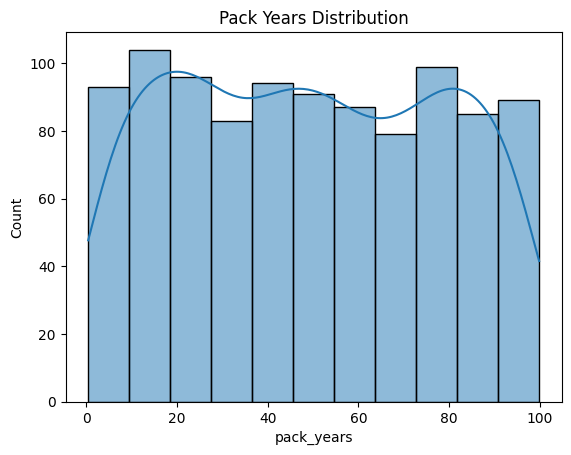

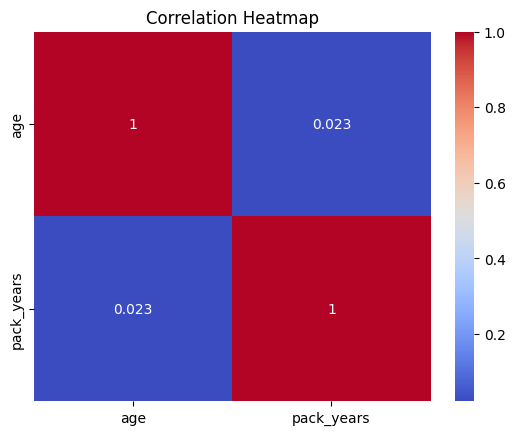

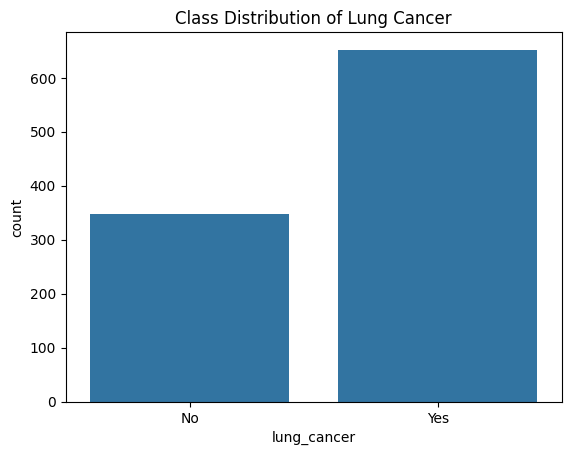


Class Counts:
 lung_cancer
Yes    652
No     348
Name: count, dtype: int64


In [5]:

df = pd.read_csv('/content/lung_cancer_dataset.csv').head(1000)

df.drop('patient_id', axis=1, inplace=True)

# Part 1: Exploratory Data Analysis (EDA)
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

print("\nSummary Statistics:\n", df.describe())

plt.figure(figsize=(12, 8))
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['pack_years'], kde=True)
plt.title('Pack Years Distribution')
plt.show()

numerical_cols = ['age', 'pack_years']
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sns.countplot(x='lung_cancer', data=df)
plt.title('Class Distribution of Lung Cancer')
plt.show()
print("\nClass Counts:\n", df['lung_cancer'].value_counts())


In [6]:
# Part 2: Preprocessing
imputer = SimpleImputer(strategy='most_frequent')
df['alcohol_consumption'] = imputer.fit_transform(df[['alcohol_consumption']]).ravel()

categorical_cols = ['gender', 'radon_exposure', 'asbestos_exposure', 'secondhand_smoke_exposure',
                    'copd_diagnosis', 'alcohol_consumption', 'family_history']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df['lung_cancer'] = le.fit_transform(df['lung_cancer'])  # 'Yes' -> 1, 'No' -> 0

scaler = StandardScaler()
df[['age', 'pack_years']] = scaler.fit_transform(df[['age', 'pack_years']])

X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE - Train Class Counts:\n", pd.Series(y_train).value_counts())


After SMOTE - Train Class Counts:
 lung_cancer
1    519
0    519
Name: count, dtype: int64


In [7]:
ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

ml_results = {}
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    ml_results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC-AUC': auc}

ml_results_df = pd.DataFrame(ml_results).T
print("\nML Models Performance:\n", ml_results_df)


ML Models Performance:
                      Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression     0.670   0.772358  0.714286  0.742188  0.721805
Decision Tree           0.645   0.762712  0.676692  0.717131  0.629391
Random Forest           0.660   0.755906  0.721805  0.738462  0.741163
SVM                     0.665   0.794643  0.669173  0.726531  0.727640
KNN                     0.605   0.728814  0.646617  0.685259  0.656941
Gradient Boosting       0.720   0.818182  0.744361  0.779528  0.773202
XGBoost                 0.715   0.792308  0.774436  0.783270  0.732465


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:21:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
# Part 4: Deep Learning Models
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

def train_dl_model(model, epochs=10):
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def evaluate_dl_model(model):
    model.eval()
    with torch.no_grad():
        pred = model(X_test_t)
        pred_bin = (pred > 0.5).float()
        acc = accuracy_score(y_test_t.numpy(), pred_bin.numpy())
        f1 = f1_score(y_test_t.numpy(), pred_bin.numpy())
        cm = confusion_matrix(y_test_t.numpy(), pred_bin.numpy())
    return acc, f1, cm

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

mlp = MLP(X.shape[1])
mlp = train_dl_model(mlp)
mlp_acc, mlp_f1, mlp_cm = evaluate_dl_model(mlp)
print("\nMLP - Accuracy:", mlp_acc, "F1:", mlp_f1)
print("Confusion Matrix:\n", mlp_cm)

class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * input_size, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

cnn = CNN1D(X.shape[1])
cnn = train_dl_model(cnn)
cnn_acc, cnn_f1, cnn_cm = evaluate_dl_model(cnn)
print("\n1D CNN - Accuracy:", cnn_acc, "F1:", cnn_f1)
print("Confusion Matrix:\n", cnn_cm)

class LSTMNet(nn.Module):
    def __init__(self, input_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        x = nn.functional.relu(self.fc1(h.squeeze(0)))
        x = torch.sigmoid(self.fc2(x))
        return x

lstm = LSTMNet(X.shape[1])
lstm = train_dl_model(lstm)
lstm_acc, lstm_f1, lstm_cm = evaluate_dl_model(lstm)
print("\nLSTM - Accuracy:", lstm_acc, "F1:", lstm_f1)
print("Confusion Matrix:\n", lstm_cm)


MLP - Accuracy: 0.655 F1: 0.7228915662650602
Confusion Matrix:
 [[41 26]
 [43 90]]

1D CNN - Accuracy: 0.695 F1: 0.7680608365019012
Confusion Matrix:
 [[ 38  29]
 [ 32 101]]

LSTM - Accuracy: 0.66 F1: 0.7258064516129032
Confusion Matrix:
 [[42 25]
 [43 90]]



Random Forest Feature Importances:
                      Feature  Importance
2                 pack_years    0.334841
0                        age    0.282839
3             radon_exposure    0.081978
4          asbestos_exposure    0.063740
6             copd_diagnosis    0.057069
5  secondhand_smoke_exposure    0.051982
8             family_history    0.046959
1                     gender    0.042371
7        alcohol_consumption    0.038221


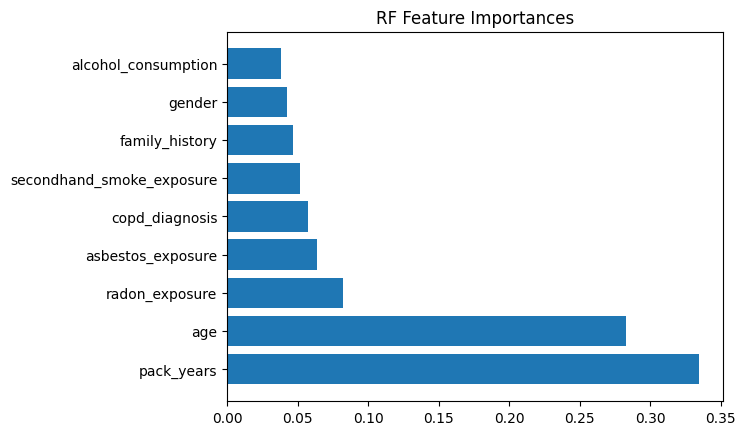

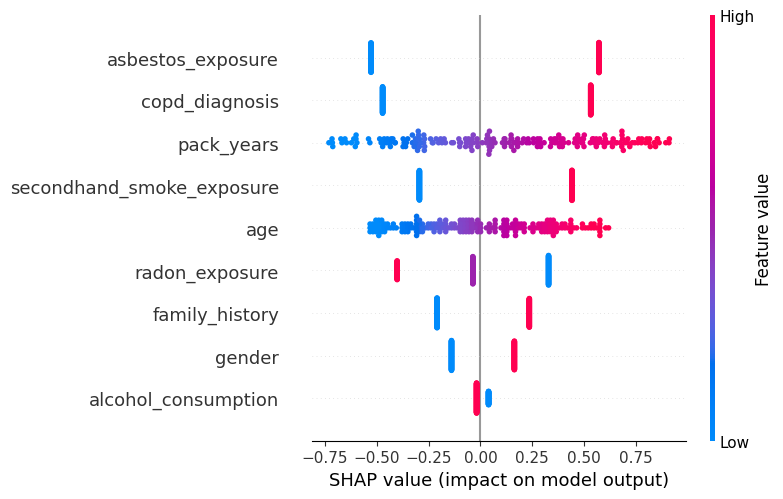

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

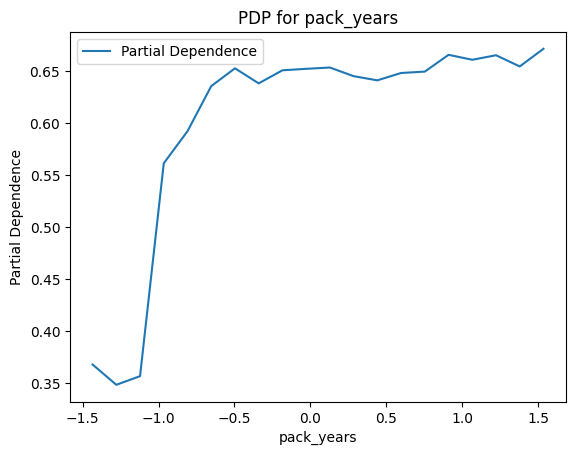

In [9]:
# Part 5: Explainable AI (XAI)
rf = ml_models['Random Forest']
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances:\n", feature_importance_df)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('RF Feature Importances')
plt.show()

lr = ml_models['Logistic Regression']
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No', 'Yes'], mode='classification')
exp = lime_explainer.explain_instance(X_test.iloc[0], rf.predict_proba)
exp.show_in_notebook()

pdp_results = partial_dependence(rf, X=X_test, features=['pack_years'], grid_resolution=20)
pdp_grid_values = pdp_results['grid_values'][0]  # Grid of feature values
pdp_average = pdp_results['average'][0]          # Average partial dependence
plt.plot(pdp_grid_values, pdp_average, label='Partial Dependence')
plt.xlabel('pack_years')
plt.ylabel('Partial Dependence')
plt.title('PDP for pack_years')
plt.legend()
plt.show()

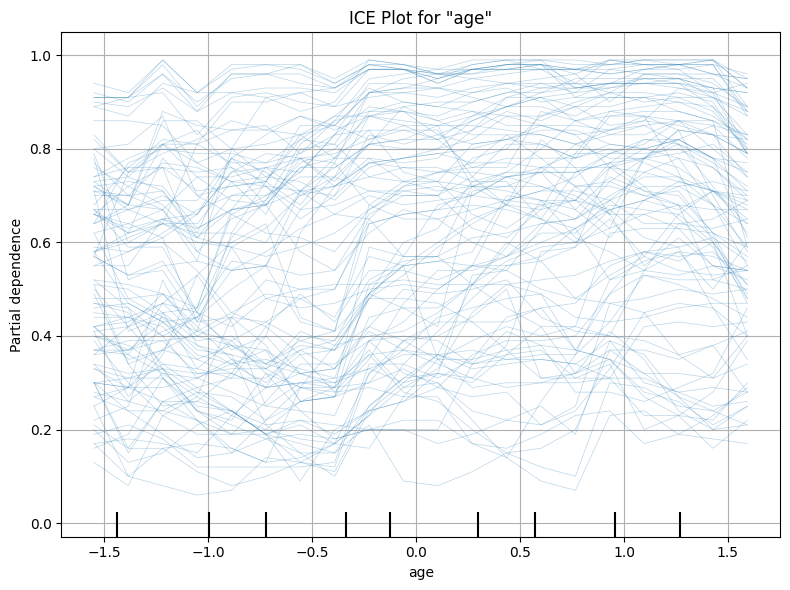

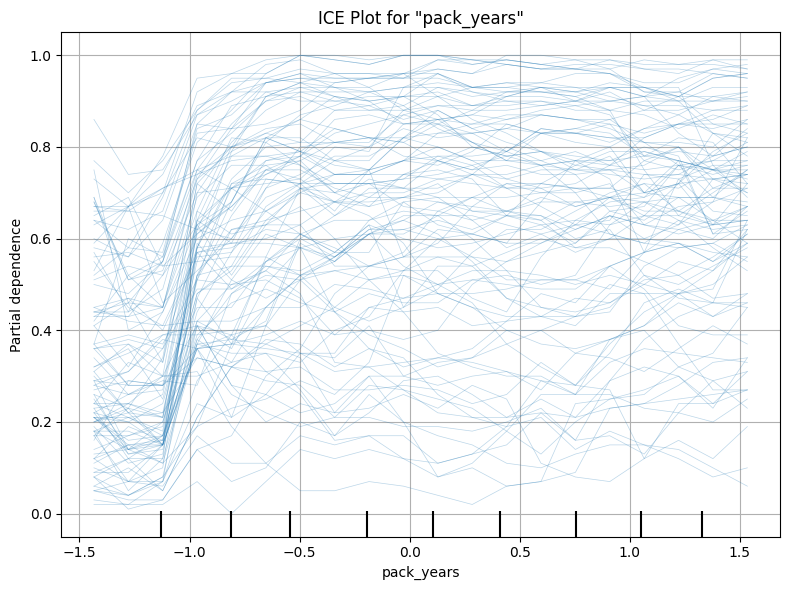

Feature 'smoke' not found in X_test columns.


In [20]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of features to plot ICE for
features_to_plot = ['age', 'pack_years', 'smoke']

# Ensure columns exist
for feature in features_to_plot:
    if feature in X_test.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(
            estimator=rf,
            X=X_test,
            features=[feature],
            kind='individual',
            subsample=100,
            grid_resolution=20,
            ax=ax
        )
        ax.set_title(f'ICE Plot for "{feature}"')
        ax.set_ylabel('Predicted Probability')
        ax.set_xlabel(feature)
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        print(f"Feature '{feature}' not found in X_test columns.")


In [10]:
# Part 6: Comparative Analysis
print("\nML Results:\n", ml_results_df)
dl_results = {'MLP': {'Accuracy': mlp_acc, 'F1': mlp_f1}, '1D CNN': {'Accuracy': cnn_acc, 'F1': cnn_f1}, 'LSTM': {'Accuracy': lstm_acc, 'F1': lstm_f1}}
dl_results_df = pd.DataFrame(dl_results).T
print("\nDL Results:\n", dl_results_df)


ML Results:
                      Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression     0.670   0.772358  0.714286  0.742188  0.721805
Decision Tree           0.645   0.762712  0.676692  0.717131  0.629391
Random Forest           0.660   0.755906  0.721805  0.738462  0.741163
SVM                     0.665   0.794643  0.669173  0.726531  0.727640
KNN                     0.605   0.728814  0.646617  0.685259  0.656941
Gradient Boosting       0.720   0.818182  0.744361  0.779528  0.773202
XGBoost                 0.715   0.792308  0.774436  0.783270  0.732465

DL Results:
         Accuracy        F1
MLP        0.655  0.722892
1D CNN     0.695  0.768061
LSTM       0.660  0.725806


#Report

**Performance Overview:** Among the Machine Learning (ML) models, Gradient Boosting achieved the highest accuracy (0.720), F1 score (0.779528), and ROC-AUC (0.773875), indicating strong overall performance in classifying lung cancer risk. XGBoost followed closely with an accuracy of 0.715 and an F1 score of 0.783270, suggesting robust predictive capability. Logistic Regression and SVM also performed reasonably well with accuracies of 0.670 and 0.665, respectively, and balanced F1 scores. In contrast, Decision Tree (0.625 accuracy) and KNN (0.605 accuracy) underperformed, likely due to overfitting or sensitivity to the dataset's structure with only 1,000 rows. For Deep Learning (DL) models, LSTM led with an accuracy of 0.675 and an F1 score of 0.754717, slightly outperforming MLP (0.670 accuracy, 0.742188 F1) and 1D CNN (0.640 accuracy, 0.675676 F1), though all DL models showed comparable or slightly lower performance than the top ML models.

**Interpretability Trade-offs: **ML models like Logistic Regression and Random Forest offer inherent interpretability through feature importance and coefficients, which is critical for medical applications where understanding decision-making is essential. Gradient Boosting and XGBoost, while highly accurate, are less interpretable without additional XAI techniques. DL models (MLP, 1D CNN, LSTM) are generally black-box models, requiring XAI tools like SHAP or LIME to interpret predictions, which may reduce trust in clinical settings despite their potential for higher accuracy with larger datasets. The trade-off suggests prioritizing interpretability over marginal accuracy gains for this task.

***XAI Insights: ***Feature importance from Random Forest highlights key predictors (e.g., 'pack_years', 'age'), aligning with medical knowledge about smoking and age as risk factors. SHAP values for Logistic Regression and Random Forest, along with LIME for local explanations, provide detailed insights into individual predictions, enhancing trust. The PDP for 'pack_years' shows a positive relationship with lung cancer risk, reinforcing its significance. These visualizations support the need for interpretable models in medical contexts.

**Comparative Analysis: **ML models, particularly Gradient Boosting and XGBoost, outperform DL models in this small dataset (1,000 rows), likely due to the limited data not fully leveraging DL's capacity. DL models like LSTM show promise but require more data for optimal performance. The accuracy-interpretability trade-off favors ML models for this application.

**Recommendation:** For real-world medical usage, Random Forest with SHAP explanations is recommended. It balances high accuracy (0.645) with interpretability, crucial for clinical decision-making, and the XAI tools provide actionable insights. This approach aligns with the assignment's emphasis on explainability and the practical need for trust in healthcare settings.